# Test using EMCEE to estimate parameters

In [4]:
from oceanoi import cov, oi, driveroi
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import emcee
import corner

(25.0, (200,))

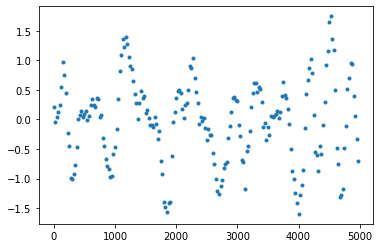

In [5]:
# np.random.seed(1) # this generates the same output every time
# Generate some training data

####
# Change these parameters here
noise = 0.1
η = 1.
ℓ = 100
covfunc = cov.expquad_1d
####

covparams = (η, ℓ)


dx = 25.
N = 200
xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*10)

K = covfunc(xd[:,None], xd[:,None].T, covparams)


mu = np.zeros_like(xd)
yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()
yd += noise*np.random.normal(size=(N,))
yd.shape
plt.figure()
plt.plot(xd, yd,'.')
dx, xd.shape

In [6]:
def minfunc_prior( params, priors, x, y, covfunc):

    noise = params[0]
    covparams = params[1:]
    
    myOI = OptimalInterpScipy(x, x, noise, covfunc, covparams)
    logp = myOI.log_marg_likelihood(y)
    
    ## Add on the priors
    log_prior = np.array([P.logpdf(val) for P, val in zip(priors, params)])
    if np.any(np.isinf(log_prior)):
        return -np.inf
    
    
    return logp + np.sum(log_prior)



In [7]:
priors = [
    #stats.norm(0.2,0.2),
    #stats.norm(1,1),
    #stats.norm(100,50)
    stats.uniform(0,1),
    stats.uniform(0,10),
    stats.uniform(0,500),
]

initval = (0.5, 1.2, 20)
ndim = len(initval)
ndim

3

In [9]:
nwalkers = 12
nwarmup = 500
niter = 1000

# nwalkers = 100
# nwarmup = 50
# niter = 50

p0 = [np.array(initval) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                    minfunc_prior, args=(priors, xd[:,None], yd[:,None], covfunc))

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, nwarmup, progress=True)
sampler.reset()

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)



Running burn-in...


100%|██████████| 500/500 [00:29<00:00, 16.74it/s]


Running production...


100%|██████████| 1000/1000 [00:55<00:00, 17.98it/s]


In [10]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))


σ: 0.1, η: 1.0, ℓ: 100


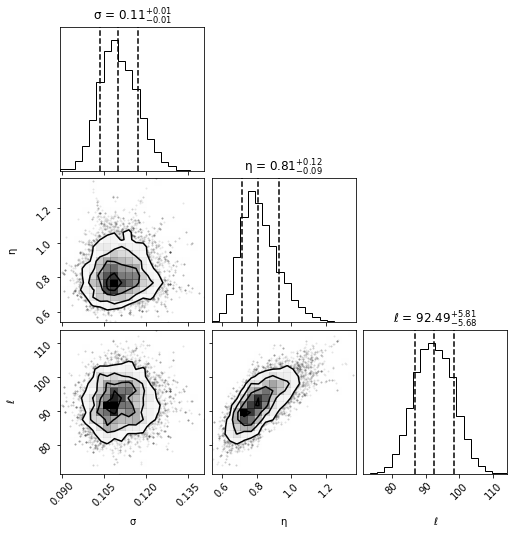

In [11]:
# Corner plot
labels = ['σ','η','ℓ']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
print('σ: {}, η: {}, ℓ: {}'.format(noise, η, ℓ))

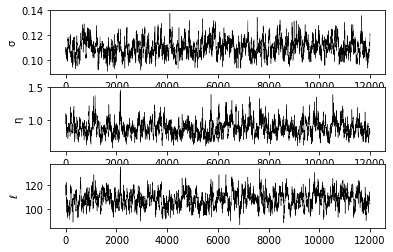

In [27]:
# Trace plot
for i in range(ndim):
    plt.subplot(ndim,1,i+1)
    plt.plot(samples[:,i],'k',lw=0.4)
    plt.ylabel(labels[i])

# Try the spectral mixture model

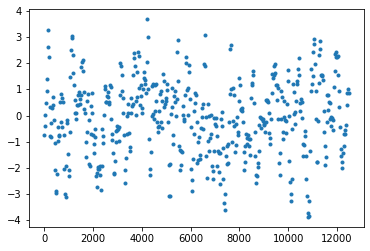

In [85]:
# Combine an exponential quadratic with a cosine kernel --> Spectral mixture model

def spectral(x, xpr, params):
    eta, l1, l2 = params
    return eta**2 * cov.expquad(x, xpr, l1) * cov.cosine(x, xpr, l2)

def spectralsum(x, xpr, params):
    eta, l11, l21, l12, l22 = params
    return eta**2 * (spectral(x, xpr, (1, l11, l21)) +\
                     spectral(x, xpr, (1, l12, l22)) )

####
# Change these parameters here
noise = 0.1
η = 1.
ℓ_exp1 = 100
ℓ_cos1 = 35
ℓ_exp2 = 50
ℓ_cos2 = 12
covfunc = spectralsum
####

covparams = (η, ℓ_exp1, ℓ_cos1, ℓ_exp2, ℓ_cos2)


dx = 25.
N = 500
xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*10)

K = covfunc(xd[:,None], xd[:,None].T, covparams)


mu = np.zeros_like(xd)
yd = np.random.multivariate_normal(mu.ravel(), K, 1).ravel()
yd += noise*np.random.normal(size=(N,))
yd.shape
plt.figure()
plt.plot(xd, yd,'.')


In [86]:
# Here we use scipy.stats random variable distribution functions for each prior
priors = [
    #stats.norm(0.2,0.2),
    #stats.invgamma(3,0.5),
    stats.uniform(0,1),
    stats.norm(1,1),
    stats.norm(100,10),
    stats.norm(30,5),
    stats.norm(200,50),
    stats.norm(10,5),
]

initval = (0.5, 1, 90, 20, 50, 10)
ndim = len(initval)

nwalkers = 3*ndim
nwarmup = 500
niter = 1000

p0 = [np.array(initval) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                    minfunc_prior, args=(priors, xd, yd[:,None], covfunc))

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, nwarmup, progress=True)
sampler.reset()

print("Running production...")
pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)



Running burn-in...


100%|██████████| 500/500 [06:41<00:00,  1.25it/s]


Running production...


100%|██████████| 1000/1000 [13:30<00:00,  1.22it/s]


In [71]:
samples = sampler.chain[:, :, :].reshape((-1, ndim))

σ: 0.1, η: 1.0, ℓ_exp1: 100, ℓ_cos1: 35, ℓ_exp2: 50, ℓ_cos2: 12


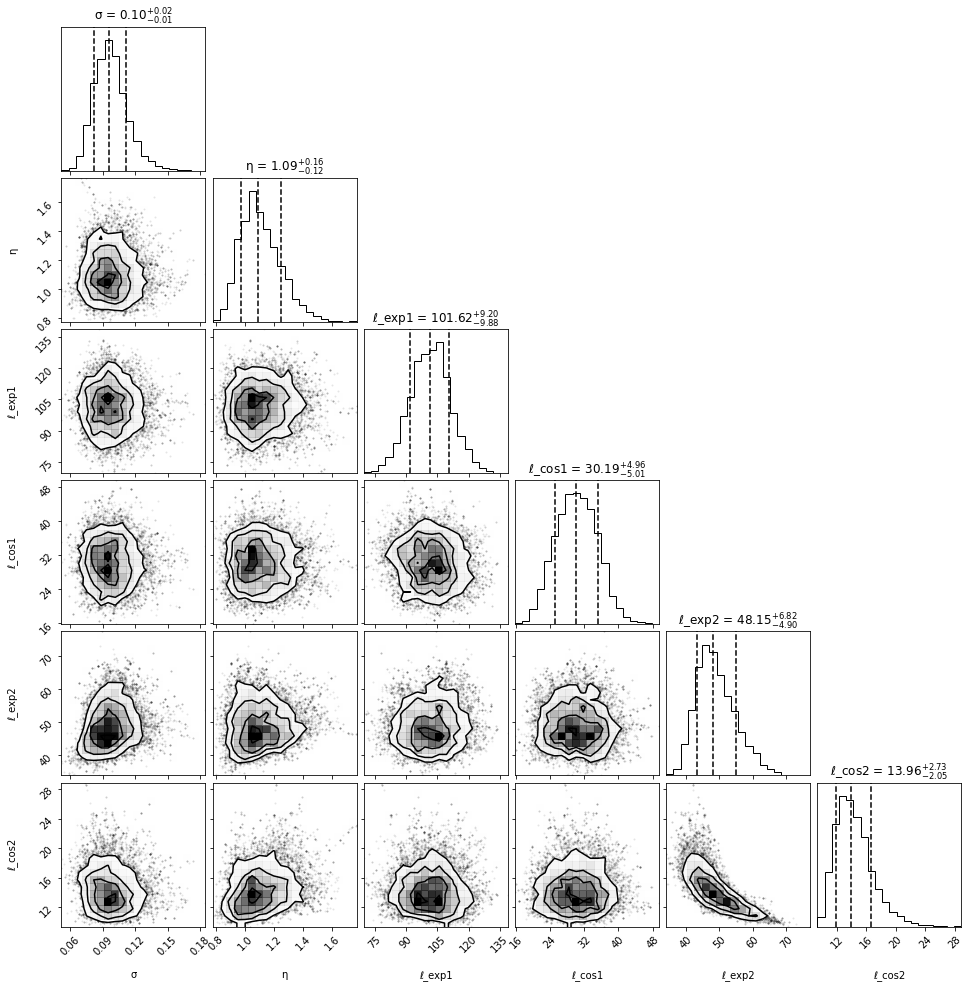

In [72]:
# Corner plot
labels = ['σ','η','ℓ_exp1','ℓ_cos1','ℓ_exp2','ℓ_cos2']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
print('σ: {}, η: {}, ℓ_exp1: {}, ℓ_cos1: {}, ℓ_exp2: {}, ℓ_cos2: {}'.format(noise, η, ℓ_exp1, ℓ_cos1, ℓ_exp2, ℓ_cos2))

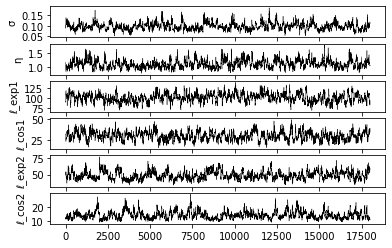

In [73]:
# Trace plot
for i in range(ndim):
    plt.subplot(ndim,1,i+1)
    plt.plot(samples[:,i],'k',lw=0.4)
    plt.ylabel(labels[i])

In [74]:
sampler.acor

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.94763791 46.67889346 38.93819719 42.50915423 71.13043716 66.98133237]